# Importing the Libraries

In [40]:
import time


import re
import nltk
from nltk.stem.snowball import SnowballStemmer
from nltk.corpus import stopwords
import gensim
import sys
import string
import time
import numpy as np
import pandas as pd
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics import mean_squared_error, make_scorer
import random
import warnings
from scipy.spatial.distance import cosine as cosine_similarity
from sklearn.cross_validation import train_test_split
from sklearn.ensemble import GradientBoostingRegressor
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from sklearn import cross_validation
import multiprocessing
from nltk.corpus import stopwords
from SpellCheck import spell_check
import logging

# A Function to convert a document to a sequence of words

In [2]:

def prodinfo_to_wordlist( prodinfo_text):
    # Function to convert a document to a sequence of words,
    # 1. Remove non-letters
    prodinfo_text = re.sub("[^a-zA-Z]"," ", prodinfo_text)
    # 2. Convert words to lower case, split them and remove stop words
    stops = set(stopwords.words("english"))
    words = " ".join([word for word in spell_check(prodinfo_text.lower()).split() if word not in stops])
    # 3. Return a list of words
    return(words)

# A function to split a prodinfo into parsed sentences

In [3]:
def prodinfo_to_sentences( prodinfo, tokenizer):
    # Function to split a prodinfo into parsed sentences. Returns a
    # list of sentences, where each sentence is a list of words
    # 1. Use the NLTK tokenizer to split the paragraph into sentences
    raw_sentences = tokenizer.tokenize(prodinfo.strip())
    # raw_sentences = tokenizer.tokenize(prodinfo.decode('utf-8').strip())
    # 2. Loop over each sentence
    sentences = []
    for raw_sentence in raw_sentences:
    # If a sentence is empty, skip it
        if len(raw_sentence) > 0:
            # Otherwise, call prodinfo_to_wordlist to get a list of words
            sentences.append( prodinfo_to_wordlist( raw_sentence ))
    # Return the list of sentences (each sentence is a list of words,
    # so this returns a list of lists
    return sentences


# Function to average all of the word vectors in a given paragraph

In [4]:
def makeFeatureVec(words, model, num_features):
    # Pre-initialize an empty numpy array (for speed)
    featureVec = np.zeros((num_features,),dtype="float32")
    nwords = 0
    # Index2word is a list that contains the names of the words in
    # the model's vocabulary. Convert it to a set, for speed
    index2word_set = set(model.wv.index2word)
    for word in words:
        if word in index2word_set:
            nwords = nwords + 1
            featureVec = np.add(featureVec,model[word])
    featureVec = featureVec//nwords
    return featureVec

# Given a set of prodinfos (each one a list of words), calculate
# the average feature vector for each one and return a 2D numpy array

In [5]:
def getAvgFeatureVecs(prodinfos, model, num_features):
    # Initialize a counter
    counter = 0
    # Preallocate a 2D numpy array, for speed
    prodinfoFeatureVecs = np.zeros((len(prodinfos),num_features),dtype="float32")
    # Loop through the prodinfos
    for prodinfo in prodinfos:
       #
       # Print a status message every 1000th prodinfo
        if counter%100 == 0:
            print ("done %d of %d" % (counter, len(prodinfos)))
       # Call the function (defined above) that makes average feature vectors
        prodinfoFeatureVecs[counter] = makeFeatureVec(prodinfo, model, num_features)
       #Increment the counter
        counter = counter + 1
    return prodinfoFeatureVecs

In [6]:
def fmean_squared_error(ground_truth, predictions):
    fmean_squared_error_ = mean_squared_error(ground_truth, predictions)**0.5
    return fmean_squared_error_

RMSE = make_scorer(fmean_squared_error, greater_is_better=False)

def RMSE(ground_truth, predictions):
    fmean_squared_error_ = mean_squared_error(ground_truth, predictions)**0.5
    return fmean_squared_error_

In [7]:
def run_est_func(params):
    n_estimators, learning_rate, max_depth, subsample = params
    n_estimators=int(n_estimators)
    print (params)
    clf = GradientBoostingRegressor(n_estimators= n_estimators, learning_rate=learning_rate, max_depth=max_depth, subsample=subsample)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    rmse = RMSE( y_test, y_pred )
    return rmse

In [8]:
def optimize(trials):
    space = (
             hp.quniform('n_estimators', 100,200, 100),
             hp.quniform('learning_rate', 0.1, 0.2, 0.1),
             hp.quniform('max_depth', 5, 6, 1),
             hp.quniform('subsample', 0.5, 1, 0.5)
             )
    best = fmin(run_est_func, space, algo=tpe.suggest, trials=trials, max_evals=10)
    print (best)

random.seed(2016)
stemmer = SnowballStemmer('english')

In [9]:
df_train = pd.read_csv('Data/train.csv', encoding="ISO-8859-1")
df_test = pd.read_csv('Data/test.csv', encoding="ISO-8859-1")
df_pro_desc = pd.read_csv('Data/product_descriptions.csv',encoding="ISO-8859-1")
df_attribute = pd.read_csv('Data/attributes.csv',encoding="ISO-8859-1")

# Looking at the data set

In [10]:
df_attribute.head(5)

,product_uid,name,value
0,100001.0,Bullet01,Versatile connector for various 90Â° connectio...
1,100001.0,Bullet02,Stronger than angled nailing or screw fastenin...
2,100001.0,Bullet03,Help ensure joints are consistently straight a...
3,100001.0,Bullet04,Dimensions: 3 in. x 3 in. x 1-1/2 in.
4,100001.0,Bullet05,Made from 12-Gauge steel


In [11]:
df_attribute[df_attribute.name == "Material"][["product_uid", "value"]].head()

,product_uid,value
8,100001.0,Galvanized Steel
67,100003.0,Composite
202,100007.0,Plastic
255,100009.0,Medium Density Fiberboard (MDF)
282,100010.0,Steel


In [12]:
df_train = pd.read_csv('Data/train.csv', encoding="ISO-8859-1")
df_test = pd.read_csv('Data/test.csv', encoding="ISO-8859-1")
df_pro_desc = pd.read_csv('Data/product_descriptions.csv',encoding="ISO-8859-1")
df_attribute = pd.read_csv('Data/attributes.csv',encoding="ISO-8859-1")
df_brand = df_attribute[df_attribute.name == "MFG Brand Name"][["product_uid", "value"]].rename(columns={"value": "brand"})
df_material = df_attribute[df_attribute.name == "Material"][["product_uid", "value"]].rename(columns={"value": "material"})

df_all = pd.concat((df_train, df_test), axis=0, ignore_index=True)
df_all = pd.merge(df_all, df_pro_desc, how='left', on='product_uid')
df_all = pd.merge(df_all, df_brand, how='left', on='product_uid')
df_material1 = df_material.drop_duplicates(['product_uid'])
df_all = pd.merge(df_all, df_material1, how='left', on='product_uid')
print (df_all.shape)

(240760, 8)


In [13]:
df_all.head()

,id,product_title,product_uid,relevance,search_term,product_description,brand,material
0,2,Simpson Strong-Tie 12-Gauge Angle,100001,3.00,angle bracket,"Not only do angles make joints stronger, they ...",Simpson Strong-Tie,Galvanized Steel
1,3,Simpson Strong-Tie 12-Gauge Angle,100001,2.50,l bracket,"Not only do angles make joints stronger, they ...",Simpson Strong-Tie,Galvanized Steel
2,9,BEHR Premium Textured DeckOver 1-gal. #SC-141 ...,100002,3.00,deck over,BEHR Premium Textured DECKOVER is an innovativ...,BEHR Premium Textured DeckOver,NaN
3,16,Delta Vero 1-Handle Shower Only Faucet Trim Ki...,100005,2.33,rain shower head,Update your bathroom with the Delta Vero Singl...,Delta,NaN
4,17,Delta Vero 1-Handle Shower Only Faucet Trim Ki...,100005,2.67,shower only faucet,Update your bathroom with the Delta Vero Singl...,Delta,NaN


In [14]:
reload (sys)
sys.setdefaultencoding('ISO-8859-1')

stop_w = ['for', 'xbi', 'and', 'in', 'th','on','sku','with','what','from','that','less','er','ing'] #'electr','paint','pipe','light','kitchen','wood','outdoor','door','bathroom'
strNum = {'zero':0,'one':1,'two':2,'three':3,'four':4,'five':5,'six':6,'seven':7,'eight':8,'nine':9}

print ("String clean ups...")
 
df_all['brand'] = np.where(df_all['brand'].isin (['n a ','na',' na','nan']),'unbrand',df_all['brand'])

regex = re.compile('[%s]' % re.escape(string.punctuation))
df_all["search_term"] = df_all["search_term"].map(lambda x: regex.sub("", x))
df_all["product_title"] = df_all["product_title"].map(lambda x: regex.sub("", x))
df_all["product_description"] = df_all["product_description"].map(lambda x: regex.sub("", x))
df_all['combined_info'] = df_all['search_term'] + " " + \
                                    df_all['product_title'] + " " + \
                                    df_all['product_description']

df_all.to_csv('Data/df_all_vect.csv',index=False)


In [15]:
df_all['combined_info'] = df_all['search_term'] + " " + \
                                    df_all['product_title'] + " " + \
                                    df_all['product_description']

df_all.to_csv('Data/df_all_vect.csv',index=False)

# Combined Feature 

In [16]:
df_all.combined_info.head()

0    angle bracket Simpson StrongTie 12Gauge Angle ...
1    l bracket Simpson StrongTie 12Gauge Angle Not ...
2    deck over BEHR Premium Textured DeckOver 1gal ...
3    rain shower head Delta Vero 1Handle Shower Onl...
4    shower only faucet Delta Vero 1Handle Shower O...
Name: combined_info, dtype: object

# We have everything now lets start training the model

In [17]:
df_all["combined_info"].size

240760

# Load the punkt tokenizer

In [18]:
tokenizer = nltk.data.load('tokenizers/punkt/english.pickle') 

In [19]:
prodinfo_to_sentences("Wait for the wait send last not so", tokenizer)[0].split()

['wait', 'wait', 'send', 'last']

In [20]:
def sentence_to_wordlist(raw):
    clean = re.sub("[^a-zA-Z]"," ", raw).lower()
    words = clean.split()
    clean_words = [word for word in words if word not in stopWords]
    return clean_words

In [21]:
sentences = []  # Initialize an empty list of sentences
vis_sentences = [] 
print ("Parsing sentences from training set")
for prodinfo in df_all["combined_info"]:
    processed = prodinfo_to_sentences(prodinfo, tokenizer)
    sentences.append(processed)
    vis_sentences.append(processed[0].split())

Parsing sentences from training set


In [22]:
token_count = sum([len(sentence) for sentence in sentences])
print("The book corpus contains {0:,} tokens".format(token_count))

The book corpus contains 240,760 tokens


In [23]:
vis_token_count = sum([len(sentence) for sentence in vis_sentences])
print("The book corpus contains {0:,} tokens".format(vis_token_count))

The book corpus contains 23,862,530 tokens


In [24]:
print (token_count)
print (vis_token_count)

240760
23862530


# Import the built-in logging module and configure it so that Word2Vec
# creates nice output messages

In [25]:
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', \
                    level=logging.INFO)

# Set values for various parameters

In [26]:
#ONCE we have vectors
#step 3 - build model
#3 main tasks that vectors help with
#DISTANCE, SIMILARITY, RANKING

# Dimensionality of the resulting word vectors.
#more dimensions, more computationally expensive to train
#but also more accurate
#more dimensions = more generalized
size = 300
# Minimum word count threshold.
min_count = 30
# Number of threads to run in parallel.
#more workers, faster we train
workers = multiprocessing.cpu_count()
# Context window length.
window = 20
# Downsample setting for frequent words.
#0 - 1e-5 is good for this
sample=1e-3
# Seed for the RNG, to make the results reproducible.
#random number generator
#deterministic, good for debugging
seed = 1

# Initialize and train the model (this will take some time) 
uncomment line below to train the model again

In [45]:
print ("Training Word2Vec model...")
import gensim.models.word2vec as w2v
model = w2v.Word2Vec(sentencessize = size, sg = 1, min_count = min_count, workers = workers, window = window
             , sample = sample, seed = seed, iter=10)

Training Word2Vec model...


In [46]:
model.build_vocab(vis_sentences)

2017-10-18 03:37:51,487 : INFO : collecting all words and their counts
2017-10-18 03:37:51,489 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2017-10-18 03:37:51,649 : INFO : PROGRESS: at sentence #10000, processed 1072517 words, keeping 41944 word types
2017-10-18 03:37:51,803 : INFO : PROGRESS: at sentence #20000, processed 2080487 words, keeping 71773 word types
2017-10-18 03:37:51,966 : INFO : PROGRESS: at sentence #30000, processed 3074928 words, keeping 96619 word types
2017-10-18 03:37:52,115 : INFO : PROGRESS: at sentence #40000, processed 4051908 words, keeping 119202 word types
2017-10-18 03:37:52,280 : INFO : PROGRESS: at sentence #50000, processed 5015779 words, keeping 140217 word types
2017-10-18 03:37:52,445 : INFO : PROGRESS: at sentence #60000, processed 5984248 words, keeping 161181 word types
2017-10-18 03:37:52,617 : INFO : PROGRESS: at sentence #70000, processed 6953712 words, keeping 180089 word types
2017-10-18 03:37:52,780 : INFO : PR

In [47]:
len(model.wv.vocab)

161505

model.train(vis_sentences, total_examples = model.corpus_count, epochs = model.iter)

model_name1 = "300features_30minwords_20context"
model.save(model_name1)

# Loading the W2v model

In [21]:
model = gensim.models.Word2Vec.load("300features_30minwords_20context")
print ('Model loaded')

# Compress the word vectors into 2D space and plot them

In [53]:
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, random_state=0)

In [54]:
all_word_vectors_matrix =  model.wv.syn0

# Training Tsne model, can take a while depending upon the machine its run

In [55]:
all_word_vectors_matrix_2d = tsne.fit_transform(all_word_vectors_matrix)

import pickle
pickle.dump(all_word_vectors_matrix_2d, open( "all_word_vector.txt", "wb" ) )

In [7]:
import pickle
file = open("all_word_vector1.txt",'rb')
all_word_vectors_matrix_2d = pickle.load(file)

# Plotting all the words

In [8]:
points = pd.DataFrame(
    [
        (word, coords[0], coords[1])
        for word, coords in [
            (word, all_word_vectors_matrix_2d[model.wv.vocab[word].index])
            for word in model.wv.vocab
        ]
    ],
    columns=["word", "x", "y"]
)

In [97]:
points[points["word"] == "bracket"]

,word,x,y
11746,bracket,-26.256432,-11.240394


In [98]:
points[points["word"] == "angle"]

,word,x,y
140713,angle,15.808227,10.498038


Populating the interactive namespace from numpy and matplotlib


C:\Anaconda3\envs\tensorflow-gpu\lib\site-packages\IPython\core\magics\pylab.py:160: UserWarning: pylab import has clobbered these variables: ['sample', 'size', 'seed', 'fmin', 'random']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


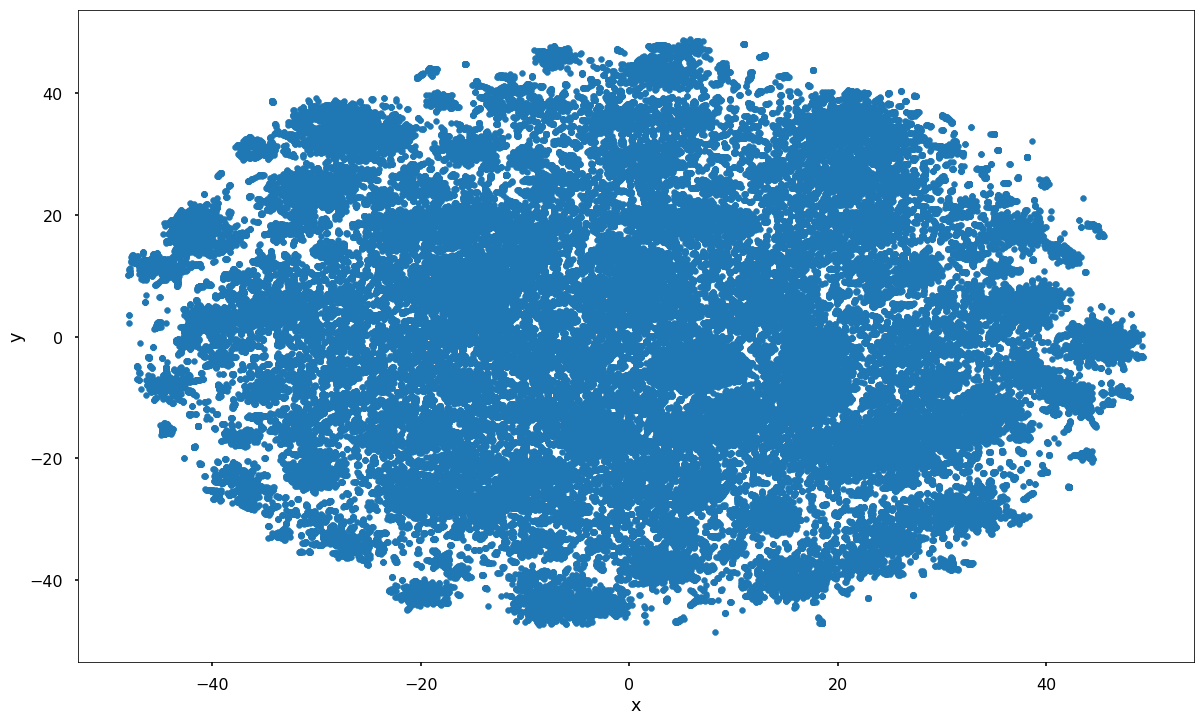

In [101]:
%pylab inline
import seaborn as sns
sns.set_context("poster")

points.plot.scatter('x', 'y', s=35, figsize=(20, 12))

# Zoom in to some interesting places

In [102]:
def plot_region(x_bounds, y_bounds):
    slice = points[
        (x_bounds[0] <= points.x) &
        (points.x <= x_bounds[1]) & 
        (y_bounds[0] <= points.y) &
        (points.y <= y_bounds[1])
    ]
    
    ax = slice.plot.scatter("x", "y", s=35, figsize=(10, 8))
    for i, point in slice.iterrows():
        ax.text(point.x + 0.005, point.y + 0.005, point.word, fontsize=11)

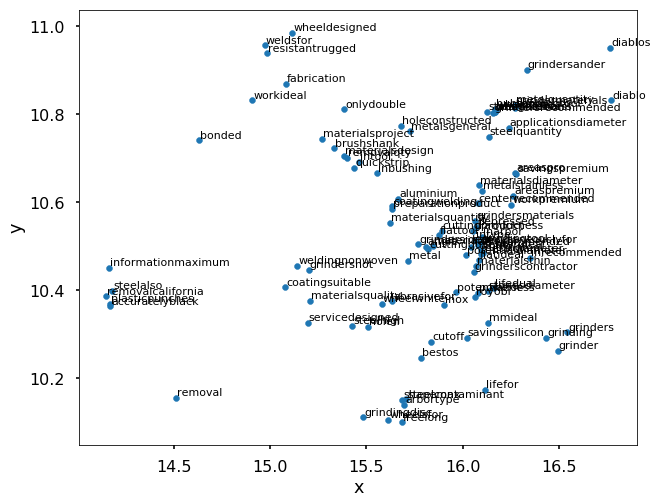

In [107]:
plot_region(x_bounds=(14,17), y_bounds=(10,11))

# Training Model with whole sentences

In [ ]:
#ONCE we have vectors
#step 3 - build model
#3 main tasks that vectors help with
#DISTANCE, SIMILARITY, RANKING

# Dimensionality of the resulting word vectors.
#more dimensions, more computationally expensive to train
#but also more accurate
#more dimensions = more generalized
size = 300
# Minimum word count threshold.
min_count = 30
# Number of threads to run in parallel.
#more workers, faster we train
workers = multiprocessing.cpu_count()
# Context window length.
window = 20
# Downsample setting for frequent words.
#0 - 1e-5 is good for this
sample=1e-3
# Seed for the RNG, to make the results reproducible.
#random number generator
#deterministic, good for debugging
seed = 1

In [30]:
model.init_sims(replace = True)

2017-10-19 20:38:49,209 : INFO : precomputing L2-norms of word weight vectors


In [28]:
print ("Training Word2Vec model...")
from gensim.models import Word2Vec
model = Word2Vec(sentences, size = size, sg = 1, min_count = min_count, workers = workers, window = window
             , sample = sample, seed = seed, iter=10)

2017-10-19 20:34:47,130 : INFO : collecting all words and their counts
2017-10-19 20:34:47,132 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2017-10-19 20:34:47,141 : INFO : PROGRESS: at sentence #10000, processed 10000 words, keeping 9928 word types
2017-10-19 20:34:47,152 : INFO : PROGRESS: at sentence #20000, processed 20000 words, keeping 19819 word types
2017-10-19 20:34:47,163 : INFO : PROGRESS: at sentence #30000, processed 30000 words, keeping 29650 word types
2017-10-19 20:34:47,176 : INFO : PROGRESS: at sentence #40000, processed 40000 words, keeping 39396 word types
2017-10-19 20:34:47,188 : INFO : PROGRESS: at sentence #50000, processed 50000 words, keeping 49016 word types
2017-10-19 20:34:47,202 : INFO : PROGRESS: at sentence #60000, processed 60000 words, keeping 58691 word types
2017-10-19 20:34:47,216 : INFO : PROGRESS: at sentence #70000, processed 70000 words, keeping 68227 word types
2017-10-19 20:34:47,236 : INFO : PROGRESS: at sentence

Training Word2Vec model...


2017-10-19 20:34:47,341 : INFO : PROGRESS: at sentence #140000, processed 140000 words, keeping 135987 word types
2017-10-19 20:34:47,358 : INFO : PROGRESS: at sentence #150000, processed 150000 words, keeping 145521 word types
2017-10-19 20:34:47,374 : INFO : PROGRESS: at sentence #160000, processed 160000 words, keeping 155076 word types
2017-10-19 20:34:47,392 : INFO : PROGRESS: at sentence #170000, processed 170000 words, keeping 164558 word types
2017-10-19 20:34:47,410 : INFO : PROGRESS: at sentence #180000, processed 180000 words, keeping 173991 word types
2017-10-19 20:34:47,436 : INFO : PROGRESS: at sentence #190000, processed 190000 words, keeping 183543 word types
2017-10-19 20:34:47,455 : INFO : PROGRESS: at sentence #200000, processed 200000 words, keeping 193111 word types
2017-10-19 20:34:47,473 : INFO : PROGRESS: at sentence #210000, processed 210000 words, keeping 202523 word types
2017-10-19 20:34:47,490 : INFO : PROGRESS: at sentence #220000, processed 220000 words, 

# Saving the Model for the Later use
model_name1 = "300features"
model.save(model_name1)

In [22]:
model = gensim.models.Word2Vec.load("300features")
print("Model Loaded")

# Calculate average feature vectors

In [26]:
df_vec.to_csv('Data/'+col+'_word2vecs.csv',index=False)

In [27]:
num_style_desc = df_all.shape[0]
for col in ['search_term','product_title','product_description']:
    cleantxt=[]
    for i in range( 0, num_style_desc ):
        if( (i+1)%10000== 0 ):
            print "vectors %d of %d\n" % ( i+1, num_style_desc )
        cleantxt.append(prodinfo_to_wordlist(df_all[col][i]) )
    print col
    vec = col+'_Vecs'
    num_features=300
    vec = getAvgFeatureVecs( cleantxt, model, num_features )
    print vec.shape
    df_vec = pd.DataFrame(vec,columns = ['vec_'+col+'_'+str(k) for k in range(num_features)])
    df_vec.to_csv('Data/'+col+'_word2vecs.csv',index=False)

In [28]:
df_all = pd.read_csv('Data/df_all_vect.csv', encoding="ISO-8859-1")
srch_vec = pd.read_csv('Data/search_term_word2vecs.csv').fillna(0.0)
pdt_ttl_vec = pd.read_csv('Data/product_title_word2vecs.csv').fillna(0.0)
pdt_desc_vec = pd.read_csv('Data/product_description_word2vecs.csv').fillna(0.0)
srch_vec = srch_vec.as_matrix(columns=[srch_vec.columns[:300]])
pdt_ttl_vec = pdt_ttl_vec.as_matrix(columns=[pdt_ttl_vec.columns[:300]])
pdt_desc_vec = pdt_desc_vec.as_matrix(columns=[pdt_desc_vec.columns[:300]])

In [41]:
warnings.filterwarnings('ignore')
dst_srch_ttl1 = np.zeros(srch_vec.shape[0])
for i in range(srch_vec.shape[0]):
    d1 = srch_vec[i, :]
    d2 = pdt_ttl_vec[i, :]
    dst_srch_ttl1[i] = cosine_similarity(d1, d2)
dst_srch_desc1 = np.zeros(srch_vec.shape[0])
for i in range(srch_vec.shape[0]):
    d1 = srch_vec[i, :]
    d2 = pdt_desc_vec[i, :]
    dst_srch_desc1[i] = cosine_similarity(d1, d2)
dst_ttl_desc1 = np.zeros(srch_vec.shape[0])
for i in range(srch_vec.shape[0]):
    d1 = pdt_ttl_vec[i, :]
    d2 = pdt_desc_vec[i, :]
    dst_srch_desc1[i] = cosine_similarity(d1, d2)

In [42]:
svd = TruncatedSVD(n_components=30, random_state=2016)

In [43]:
srch_vec = svd.fit_transform(srch_vec)
pdt_ttl_vec = svd.fit_transform(pdt_ttl_vec)
pdt_desc_vec = svd.fit_transform(pdt_desc_vec)

In [44]:
srch_vec = pd.DataFrame(srch_vec, columns=['srch_vec_' + str(i) for i in range(srch_vec.shape[1])])
pdt_ttl_vec = pd.DataFrame(pdt_ttl_vec, columns=['ttl_vec_' + str(i) for i in range(pdt_ttl_vec.shape[1])])
pdt_des c_vec = pd.DataFrame(pdt_desc_vec, columns=['desc_vec_' + str(i) for i in range(pdt_desc_vec.shape[1])])

In [46]:
id = list(df_all['id'])
srch_vec['id'] = id
pdt_ttl_vec['id'] = id
pdt_desc_vec['id'] = id

df_all = pd.merge(df_all, srch_vec, how='left', on='id')
df_all = pd.merge(df_all, pdt_ttl_vec, how='left', on='id')
df_all = pd.merge(df_all, pdt_desc_vec, how='left', on='id')

df_all['dst_srch_ttl1'] = dst_srch_ttl1
df_all['dst_srch_desc1'] = dst_srch_desc1
df_all['dst_ttl_desc1'] = dst_ttl_desc1

cols = list(df_all.select_dtypes(include=['object']).columns)

df_all1 = df_all.drop(cols, 1)
df_all1.to_csv('Data/df_all_new_feat3.csv', index=False)

In [72]:
# Training
df_all = pd.read_csv('Data/df_all_new_feat3.csv', encoding="ISO-8859-1")

df_val = df_all[df_all['relevance'].isnull()]
df_train = df_all[~df_all['relevance'].isnull()]
id_val = df_val['id']
df_train.fillna(0)
y_train = df_train['relevance'].values

X_train, X_test, y_train, y_test = train_test_split(df_train, y_train, test_size=0.3, random_state=1234)

X_train = X_train.drop(['id', 'relevance'], axis=1)
X_test = X_test.drop(['id', 'relevance'], axis=1)

In [69]:
    df_val = df_all[df_all['relevance'].isnull()]
    df_train = df_all[~df_all['relevance'].isnull()]
    id_val = df_val['id']
    y_train = df_train['relevance'].values

    X_train = df_train.drop(['id', 'relevance'], axis=1)
    X_test = df_val.drop(['id', 'relevance'], axis=1)

In [70]:
clf = GradientBoostingRegressor(n_estimators=340, learning_rate=0.15, max_depth=4, subsample=0.75)
#t0 = time.time()
#scores = cross_validation.cross_val_score(clf, X_train, y_train, cv=3, scoring="mean_squared_error", n_jobs=-1)
#print scores
#print 'Cross Val time taken:', (time.time() - t0) / 60.0, 'minutes'

In [71]:
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

min_y_pred = min(y_pred)
max_y_pred = max(y_pred)
min_y_train = min(y_train)
max_y_train = max(y_train)
print(min_y_pred, max_y_pred, min_y_train, max_y_train)
for i in range(len(y_pred)):
    if y_pred[i] < 1.0:
        y_pred[i] = 1.0
    if y_pred[i] > 3.0:
        y_pred[i] = 3.0

id_test = df_val['id']
pd.DataFrame({"id": id_test, "relevance": y_pred}).to_csv('submission.csv', index=False)

ValueError: Input contains NaN, infinity or a value too large for dtype('float32').